In [1]:
import sys
sys.path.append('..')
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import datetime
import theano_lstm
import numpy as np
import data_managers
import os
import cPickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X


In [2]:
reload(data_managers)
data_butler = data_managers.character_data_manager('/home/arimorcos/Github/CS281-Final-Project/data manager/')
data_butler.convert_ent_to_one_hot()

In [3]:
%%time
# Create network 
config.mode="FAST_RUN"
hidden_size = 128
network = theano_lstm.lstm_rnn(300,
                  [(hidden_size, hidden_size)],
                  150, dropout=0.2)
# network.initialize_training_adadelta()
network.initialize_training_adam(alpha=5e-5, beta1=0.9)

CPU times: user 1min 25s, sys: 572 ms, total: 1min 25s
Wall time: 1min 25s


In [4]:
network.save_model('man.pkl')

In [ ]:
%%time
# Load 
with open('ban.pkl', 'rb') as f:
    network = cPickle.load(f)

In [5]:
grad_fun = function(network._lstm_rnn__inp_list, network.adam_grads[0])

In [15]:
network.initialize_network_weights(scale_down=0.6, b_f_offset=0.75)
vectors, lengths, answers = data_butler.offer_data()
np.linalg.norm(grad_fun(vectors, lengths, answers), axis=1)

array([ 5.        ,  5.        ,  5.        ,  5.        ,  5.00000048,
        5.00000048,  5.        ,  5.        ,  5.        ,  5.        ,
        4.99999952,  5.        ,  5.        ,  5.        ,  5.        ,
        5.        ,  5.        ,  5.        ,  5.00000048,  4.99999952,
        5.        ,  5.        ,  5.00000048,  4.99999952,  5.        ,
        4.99999952,  5.00000048,  5.00000095,  5.00000048,  5.        ,
        4.99999952,  5.        ,  5.        ,  5.        ,  4.99999952,
        5.        ,  4.99999952,  5.00000048,  5.        ,  5.        ,
        4.99999952,  5.        ,  5.        ,  4.99999952,  5.        ,
        4.99999952,  5.        ,  5.        ,  4.99999952,  5.        ,
        5.        ,  5.00000048,  5.        ,  5.00000048,  5.        ,
        4.99999952,  5.        ,  5.        ,  5.        ,  5.00000048,
        5.        ,  5.        ,  5.        ,  4.99999952,  5.        ,
        5.00000048,  5.        ,  5.00000048,  4.99999952,  5.00

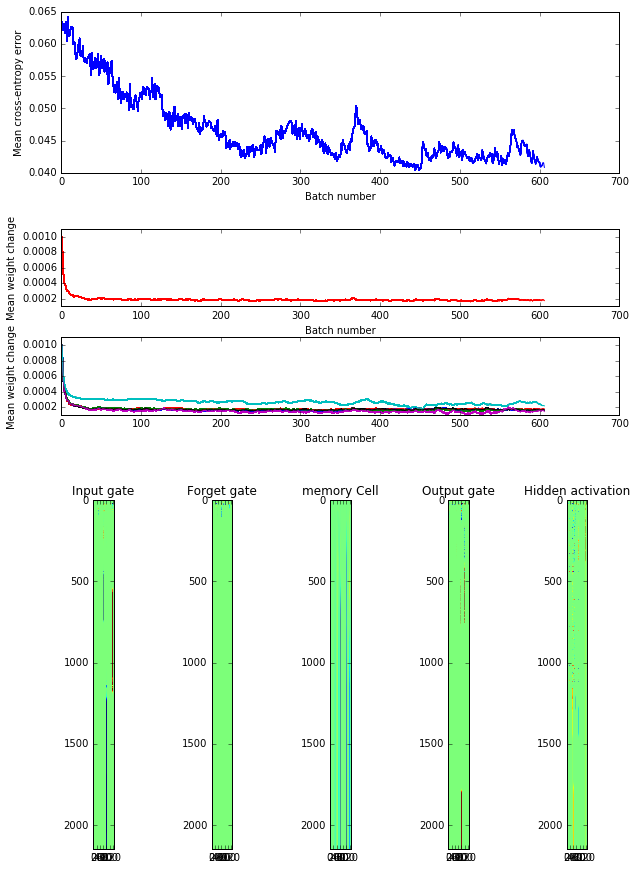

KeyboardInterrupt: 

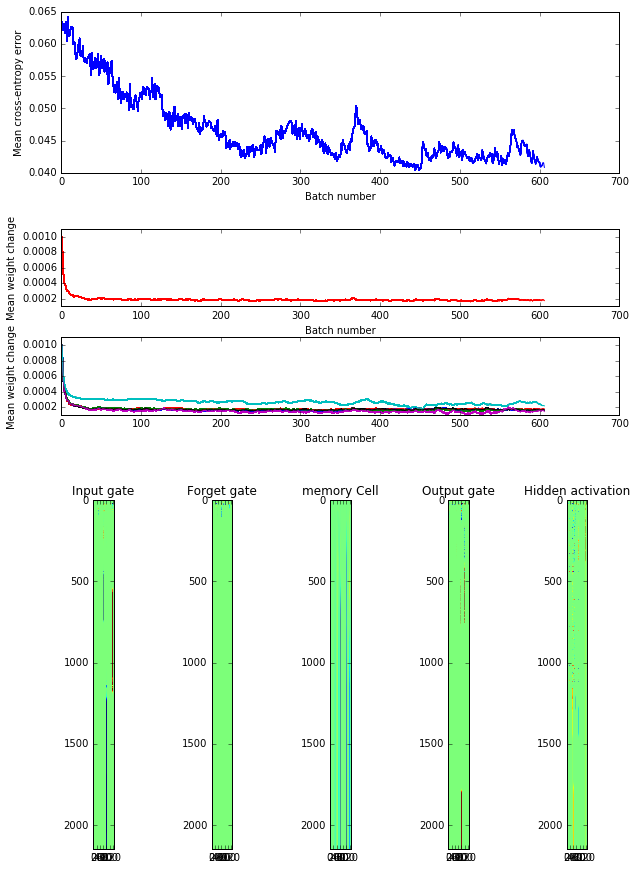

In [18]:
batch_size = 100
perms_per = 2
num_batches = 100000
should_reinitialize = True
repeat_batch = 1
# abbrev = 10

data_butler.set_batch_size(batch_size)
data_butler.set_perms_per(perms_per)
data_butler.set_stride(batch_size)
# data_butler.set_stride(0)

# Re-initialize network 
if should_reinitialize:
    network.initialize_network_weights(scale_down=0.6, b_f_offset=0.75)
    network.reset_adam(grad_max_norm=5, alpha=0.001)
    root_dir = '/media/1_TB_Internal/lstm_rnn_data'
    new_log_dir = os.path.join(root_dir, datetime.datetime.now().strftime('%y%m%d_%H%M%S'))
    network.set_log_dir(new_log_dir)
    # TEMPORARY: Scale down the weights to avoid getting nans
#     for P in network.list_all_params():
#         P.set_value(P.get_value()*0.525)
    
    # Initialize cost 
    cost = []
    mean_diff_mag = []
    mean_diff_mag_i = []
    mean_diff_mag_f = []
    mean_diff_mag_c = []
    mean_diff_mag_o = []
    mean_diff_mag_y = []
    mean_diff_mag_r = []
    should_crop = True

#Create plot 
fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax_cost = fig.add_subplot(4,1,1)
ax_cost.set_xlabel('Batch number')
ax_cost.set_ylabel('Mean cross-entropy error')
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax_cost.yaxis.set_major_formatter(y_formatter)

ax_weight_change = fig.add_subplot(8,1,3)
ax_weight_change.set_xlabel('Batch number')
ax_weight_change.set_ylabel('Mean weight change')

ax_weight_change_ind = fig.add_subplot(8,1,4)
ax_weight_change_ind.set_xlabel('Batch number')
ax_weight_change_ind.set_ylabel('Mean weight change')
ax_weight_change_ind.hold(True)

# Plot the difference in hidden unit activations comparing different permutations (assumes perms_per > 1)
labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(2,len(labels),(1*len(labels))+sp+1))


offset = 0
# Offer data
# vectors, lengths, answers = data_butler.offer_data()
# vectors = vectors[:abbrev, :, :]
# lengths = [min(abbrev, vec_len) for vec_len in lengths]

for batch in range(num_batches):
    
    # Get data
#     vectors, lengths, answers = data_butler.permute_examples()
#     vectors = vectors[:abbrev, :, :]
#     lengths = [min(abbrev, vec_len) for vec_len in lengths]

    vectors, lengths, answers = data_butler.offer_data()
    
    offset = offset + perms_per
    if offset >= batch_size*perms_per: 
        offset = 0
    
    # Step 
#     temp_cost, param_diff = network.adadelta_step(vectors, lengths, answers)
    for repeat in range(repeat_batch):
        temp_cost, param_diff = network.adam_step(vectors, lengths, answers)
        cost.append(temp_cost.tolist())
    
        # Calculate mean param_diff magnitude
        temp_mean_diff_mag = [np.abs(diff).mean() for diff in param_diff]
        mean_diff_mag.append(np.mean(temp_mean_diff_mag))
        
        # append indi
        mean_diff_mag_i.append(temp_mean_diff_mag[0])
        mean_diff_mag_f.append(temp_mean_diff_mag[2])
        mean_diff_mag_c.append(temp_mean_diff_mag[4])
        mean_diff_mag_o.append(temp_mean_diff_mag[6])
        mean_diff_mag_y.append(temp_mean_diff_mag[8])
        mean_diff_mag_r.append(temp_mean_diff_mag[10])

        # Update plot 
        
        try:
            upper_lim = len(cost) + 1
        except:
            upper_lim = 2
        x_vals = range(1, upper_lim)
        x_vals_diff = range(1, upper_lim)
        ax_cost.plot(x_vals, cost, 'b')
        ax_weight_change.plot(x_vals_diff, mean_diff_mag, 'r')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_i, 'b')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_f, 'r')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_c, 'g')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_o, 'k')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_y, 'm')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_r, 'c')
        
        
        ind = np.array([0, 1])
        ind += offset
        for ax,gtp,T in zip(ax_list, network.hidden_activations(vectors[:, :, ind]), labels):
            ax.imshow(gtp[:,:,1]-gtp[:,:,0])
            ax.set_title(T)
        
        display.clear_output(wait=True)
        display.display(fig)
    
    data_butler.advance_schedule()

In [21]:
with open( network.get_log_dir() + '/butler.pkl', 'wb' ) as f:
    cPickle.dump(data_butler,f)

In [1]:
cost

NameError: name 'cost' is not defined

In [ ]:
mean_diff_mag_y[:] = mean_diff_mag_c[5]

In [ ]:
network.initialize_network_weights()
network.do_max_norm_reg()
p = network.list_all_params()
w_i = p[0].get_value()
norms = []
for row in range(w_i.shape[0]):
    norms.append(np.linalg.norm(w_i[row, :]))
plt.plot(norms)

ValueError: operands could not be broadcast together with shapes (1568,128) (1388,128) 

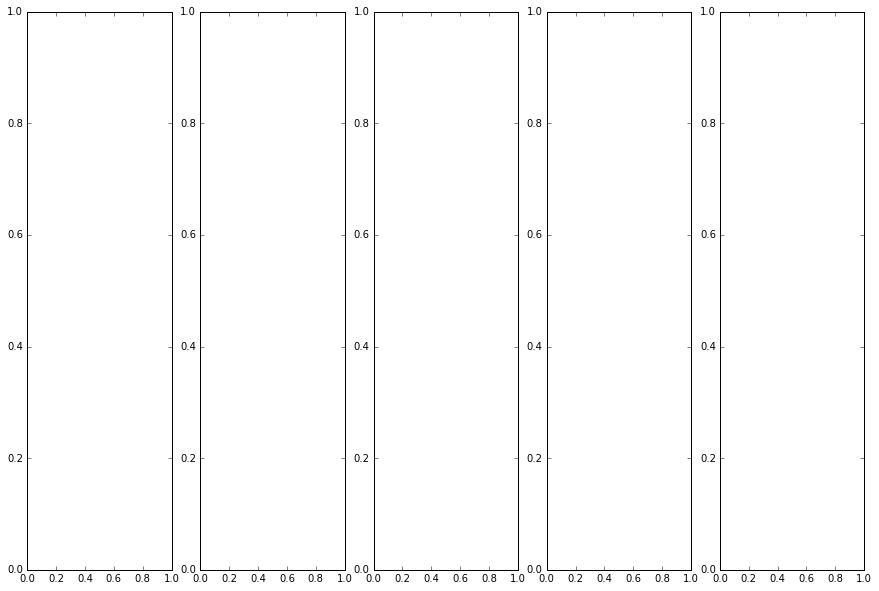

In [16]:
# network.initialize_network_weights()

# p = network.list_all_params()
# for P in p:
#     P.set_value(P.get_value()*0.6)
#     P.set_value(np.random.uniform(
#             low=-1./np.sqrt(128),
#             high=1./np.sqrt(128),
#             size=P.get_value().shape
#         ).astype(config.floatX))
# network.do_max_norm_reg()

labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
fig = plt.figure(figsize=(15,10))

ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(1,len(labels),sp+1))

hidden_players = network.hidden_activations(vectors[:,:,:2])
for ax,gtp,T in zip(ax_list, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1]-gtp[:lengths[0],:,0])
    #ax.imshow(gtp[:,:,0])
    ax.set_title(T)
    
plt.figure()
plt.axes().plot( np.mean(np.abs(hidden_players[4][:lengths[1],:256,1]-hidden_players[4][:lengths[0],:256,0]),axis=1) );

In [ ]:
plt.hist(hidden_players[2][-10:, :].flatten(), bins=50);